# YOLO V2 with TensorFlow 2.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import imgaug as ia
from imgaug import augmenters as iaa
from math import ceil

In [4]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda

Tensorflow version : 2.3.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# load tensorboard -- better to run tensorboard on a different jupyter notebook
#%load_ext tensorboard

In [6]:
#to skip training replace training_name with an empty string
#if you skip training an old model with weights in "weights/training_name" is loaded
SKIP_TESTS = True
training_name = 'training_4'
weights_to_load = 'training_4'
weights_name = 'weights/' + weights_to_load + '.h5'
SKIP_TRAIN = True

In [7]:
# directories

# current Google Drive directory
currDriveDir = 'drive/My Drive/Colab Notebooks/mqi-project/'
# Train and validation directory
train_image_folder = currDriveDir + 'data/train/image/'
train_annot_folder = currDriveDir + 'data/train/annotation/'
val_image_folder = currDriveDir + 'data/val/image/'
val_annot_folder = currDriveDir + 'data/val/annotation/'
# logs and weights directories
log_folder = currDriveDir + 'logs'
trained_weights = currDriveDir + weights_name 

In [8]:
# Parameters

LABELS           = ('car', 'truck', 'bicycle')
IMAGE_H, IMAGE_W = 512, 512
GRID_H,  GRID_W  = 16, 16 # GRID size = IMAGE size / 32

scale = IMAGE_W / GRID_W

BOX              = 5
CLASS            = len(LABELS)
totClass         = [225, 258, 304]      # position i stores the total number of boxes of class LABELS[i]

# SCORE_THRESHOLD is not an "objectness" threshold but a class confidence score (objectness * class probability)
#SCORE_THRESHOLD  = 0.5
SCORE_THRESHOLD  = 0.5    # THIS SCORE_THRESHOLD IS USED TO FILTER PREDICTED BBOXES
#IOU_THRESHOLD    = 0.45
IOU_THRESHOLD    = 0.45   #IOU THRESHOLD FOR NONMAX SUPPRESSION
IOU_THRESHOLD_AP = 0.5    #IOU THRESHOLD FOR AVERAGE PRECISION mAP@.5
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

# number of train pictures and validation pictures
train_size       = len(glob.glob(train_image_folder+'*'))     # 1398
val_size         = len(glob.glob(val_image_folder+'*'))       # 340

TRAIN_BATCH_SIZE = 10
VAL_BATCH_SIZE   = 10                                         # 10

# number of batches used for steps per epoch
n_train_batches  = ceil(train_size / TRAIN_BATCH_SIZE)        # 140
n_val_batches    = ceil(val_size / VAL_BATCH_SIZE)            # 34

# 20/30 are enough, test 2/3/5
EPOCHS           = 10     # Each epoch iterates through the whole train dataset (also validation to compute val_loss)

LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

max_annot        = 0

# 1. Define YOLO model

In [9]:
# Custom Keras layer

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

In [10]:
# Yolo model (thanks to https://github.com/experiencor/keras-yolo2)

input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, BOX, 4 + 1 + CLASS))(x)

model = keras.models.Model(input_image, output)

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 512, 512, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 512, 512, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

# 2. Load YOLO pretrained weigts

In [12]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

In [13]:
if not SKIP_TRAIN:  
  weight_reader = WeightReader(currDriveDir + 'yolo.weights')

  weight_reader.reset()
  nb_conv = 23

  for i in range(1, nb_conv+1):
      conv_layer = model.get_layer('conv_' + str(i))
      conv_layer.trainable = True

      if i < nb_conv:
          norm_layer = model.get_layer('norm_' + str(i))
          norm_layer.trainable = True

          size = np.prod(norm_layer.get_weights()[0].shape)

          beta  = weight_reader.read_bytes(size)
          gamma = weight_reader.read_bytes(size)
          mean  = weight_reader.read_bytes(size)
          var   = weight_reader.read_bytes(size)

          weights = norm_layer.set_weights([gamma, beta, mean, var])       

      if len(conv_layer.get_weights()) > 1:
          bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel, bias])
      else:
          kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel])


  layer   = model.layers[-2] # last convolutional layer
  layer.trainable = True

  weights = layer.get_weights()

  new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
  new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

  layer.set_weights([new_kernel, new_bias])

# 3. Data generator

In [14]:
def parse_annotation(ann_dir, img_dir, labels):
    '''
    Parse XML files in PASCAL VOC format.
    
    Parameters
    ----------
    - ann_dir : annotations files directory
    - img_dir : images files directory
    - labels : labels list
    
    Returns
    -------
    - imgs_name : numpy array of images files path (shape : images count, 1)
    - true_boxes : numpy array of annotations for each image (shape : image count, max annotation count, 5)
        annotation format : xmin, ymin, xmax, ymax, class
        xmin, ymin, xmax, ymax : image unit (pixel)
        class = label index
    '''
    
    max_annot = 0
    imgs_name = []
    annots = []
    
    # Parse file
    for ann in sorted(os.listdir(ann_dir)):
        annot_count = 0
        boxes = []
        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter(): 
            if 'filename' in elem.tag:
                imgs_name.append(img_dir + elem.text)
            if 'width' in elem.tag:
                w = int(elem.text)
            if 'height' in elem.tag:
                h = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:                  
                box = np.zeros((5))
                for attr in list(elem):
                    if 'name' in attr.tag:
                        box[4] = labels.index(attr.text) + 1 # 0:label for no bounding box
                    if 'bndbox' in attr.tag:
                        annot_count += 1
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                box[0] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                box[1] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                box[2] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                box[3] = int(round(float(dim.text)))
                boxes.append(np.asarray(box))
        
        if w != IMAGE_W or h != IMAGE_H :
            print('Image size error')
            break
            
        annots.append(np.asarray(boxes))
        

        if annot_count > max_annot:
            max_annot = annot_count
           
    # Rectify annotations boxes : len -> max_annot
    imgs_name = np.array(imgs_name)  
    true_boxes = np.zeros((imgs_name.shape[0], max_annot, 5))
    for idx, boxes in enumerate(annots):
        true_boxes[idx, :boxes.shape[0], :5] = boxes
        
    return imgs_name, true_boxes

## 3.1. Dataset

In [15]:
def parse_function(img_obj, true_boxes):
    x_img_string = tf.io.read_file(img_obj)
    x_img = tf.image.decode_png(x_img_string, channels=3) # dtype=tf.uint8
    x_img = tf.image.convert_image_dtype(x_img, tf.float32) # pixel value /255, dtype=tf.float32, channels : RGB
    return x_img, true_boxes

In [16]:
def get_dataset(img_dir, ann_dir, labels, batch_size, train=True):
    '''
    Create a YOLO dataset
    
    Parameters
    ----------
    - ann_dir : annotations files directory
    - img_dir : images files directory
    - labels : labels list
    - batch_size : int
    
    Returns
    -------
    - YOLO dataset : generate batch
        batch : tupple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
    Note : image pixel values = pixels value / 255. channels : RGB
    '''
    imgs_name, bbox = parse_annotation(ann_dir, img_dir, LABELS)
    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, bbox)) 
    if train:
      dataset = dataset.shuffle(len(imgs_name))
    dataset = dataset.repeat()
    dataset = dataset.map(parse_function, num_parallel_calls=6)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    print('-------------------')
    print('Dataset:')
    print('Images count: {}'.format(len(imgs_name)))
    print('Step per epoch: {}'.format(len(imgs_name) // batch_size))
    print('Images per epoch: {}'.format(batch_size * (len(imgs_name) // batch_size)))
    return dataset

In [47]:
if not SKIP_TRAIN:
  train_dataset = None
  train_dataset = get_dataset(train_image_folder, train_annot_folder, LABELS, TRAIN_BATCH_SIZE)

val_dataset = None
val_dataset = get_dataset(val_image_folder, val_annot_folder, LABELS, VAL_BATCH_SIZE, train=False)

-------------------
Dataset:
Images count: 340
Step per epoch: 34
Images per epoch: 340


In [18]:
# Test dataset

def test_dataset(dataset):
    for batch in dataset:
        img = batch[0][0]     #since we are using numpy arrays \ tensorflow tensors (vertical arrays/columns) the first index is used for img or label
        label = batch[1][0]
        plt.figure(figsize=(2,2))
        f, (ax1) = plt.subplots(1,1, figsize=(10, 10))
        ax1.imshow(img)
        ax1.set_title('Input image. Shape : {}'.format(img.shape))
        for i in range(label.shape[0]):
            box = label[i,:]
            box = box.numpy()
            x = box[0]
            y = box[1]
            w = box[2] - box[0]
            h = box[3] - box[1]
            color = {0:(1,0,0),1:(0,1,0),2:(0,0,1)}
            rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor=color.get(box[4]-1,(1,1,1)),facecolor='none')
            ax1.add_patch(rect)
        break

if not SKIP_TESTS:        
  test_dataset(train_dataset)

## 3.2. Data augmentation

In [19]:
def augmentation_generator(yolo_dataset):
    '''
    Augmented batch generator from a yolo dataset

    Parameters
    ----------
    - YOLO dataset
    
    Returns
    -------
    - augmented batch : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch : tupple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
    '''
    for batch in yolo_dataset:
        # conversion tensor->numpy
        img = batch[0].numpy()
        boxes = batch[1]. numpy()
        # conversion bbox numpy->ia object
        ia_boxes = []
        for i in range(img.shape[0]):
            ia_bbs = [ia.BoundingBox(x1=bb[0],
                                       y1=bb[1],
                                       x2=bb[2],
                                       y2=bb[3]) for bb in boxes[i]
                      if (bb[0] + bb[1] +bb[2] + bb[3] > 0)]
            ia_boxes.append(ia.BoundingBoxesOnImage(ia_bbs, shape=(IMAGE_W, IMAGE_H)))
        # data augmentation
        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            #iaa.Flipud(0.5),         # we will never have flipped cars or vehicles, this augmentation is not useful
            iaa.Multiply((0.4, 1.6)), # change brightness
            iaa.ContrastNormalization((0.5, 1.5)),
            #iaa.Affine(translate_px={"x": (-100,100), "y": (-100,100)}, scale=(0.7, 1.30))
            ])
        #seq = iaa.Sequential([])
        seq_det = seq.to_deterministic()
        img_aug = seq_det.augment_images(img)
        img_aug = np.clip(img_aug, 0, 1)
        boxes_aug = seq_det.augment_bounding_boxes(ia_boxes)
        # conversion ia object -> bbox numpy
        for i in range(img.shape[0]):
            boxes_aug[i] = boxes_aug[i].remove_out_of_image().clip_out_of_image()
            for j, bb in enumerate(boxes_aug[i].bounding_boxes):
                boxes[i,j,0] = bb.x1
                boxes[i,j,1] = bb.y1
                boxes[i,j,2] = bb.x2
                boxes[i,j,3] = bb.y2
        # conversion numpy->tensor
        batch = (tf.convert_to_tensor(img_aug), tf.convert_to_tensor(boxes))
        #batch = (img_aug, boxes)
        yield batch

In [20]:
if not SKIP_TRAIN:
  aug_train_dataset = augmentation_generator(train_dataset)
  if not SKIP_TESTS:
    test_dataset(aug_train_dataset)

## 3.3. Process data to YOLO prediction format

In [21]:
def process_true_boxes(true_boxes, anchors, image_width, image_height):
    '''
    Build image ground truth in YOLO format from image true_boxes and anchors.
    
    Parameters
    ----------
    - true_boxes : tensor, shape (max_annot, 5), format : x1 y1 x2 y2 c, coords unit : image pixel
    - anchors : list [anchor_1_width, anchor_1_height, anchor_2_width, anchor_2_height...]
        anchors coords unit : grid cell
    - image_width, image_height : int (pixels)
    
    Returns
    -------
    - detector_mask : array, shape (GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : array, shape (GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - true_boxes_grid : array, same shape than true_boxes (max_annot, 5),
        format : x, y, w, h, c, coords unit : grid cell
        
    Note:
    -----
    Bounding box in YOLO Format : x, y, w, h, c
    x, y : center of bounding box, unit : grid cell
    w, h : width and height of bounding box, unit : grid cell
    c : label index
    ''' 
    
    scale = IMAGE_W / GRID_W # scale = 32
    
    anchors_count = len(anchors) // 2
    anchors = np.array(anchors)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    detector_mask = np.zeros((GRID_W, GRID_H, anchors_count, 1))
    matching_true_boxes = np.zeros((GRID_W, GRID_H, anchors_count, 5))
    
    # convert true_boxes numpy array -> tensor
    true_boxes = true_boxes.numpy()
    
    true_boxes_grid = np.zeros(true_boxes.shape)
    
    # convert bounding box coords and localize bounding box
    for i, box in enumerate(true_boxes):
        # convert box coords to x, y, w, h and convert to grids coord
        w = (box[2] - box[0]) / scale
        h = (box[3] - box[1]) / scale    
        x = ((box[0] + box[2]) / 2) / scale
        y = ((box[1] + box[3]) / 2) / scale
        true_boxes_grid[i,...] = np.array([x, y, w, h, box[4]])
        if w * h > 0: # box exists
            # calculate iou between box and each anchors and find best anchors
            best_iou = 0
            best_anchor = 0
            for i in range(anchors_count): 
                # iou (anchor and box are shifted to 0,0)
                intersect = np.minimum(w, anchors[i,0]) * np.minimum(h, anchors[i,1])
                union = (anchors[i,0] * anchors[i,1]) + (w * h) - intersect
                iou = intersect / union
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = i
            # localize box in detector_mask and matching true_boxes
            if best_iou > 0:
                x_coord = np.floor(x).astype('int')
                y_coord = np.floor(y).astype('int')
                detector_mask[y_coord, x_coord, best_anchor] = 1
                yolo_box = np.array([x, y, w, h, box[4]])
                matching_true_boxes[y_coord, x_coord, best_anchor] = yolo_box
    return matching_true_boxes, detector_mask, true_boxes_grid

In [22]:
def ground_truth_generator(dataset):
    '''
    Ground truth batch generator from a yolo dataset, ready to compare with YOLO prediction in loss function.

    Parameters
    ----------
    - YOLO dataset. Generate batch:
        batch : tuple(images, annotations)
        batch[0] : images : tensor (shape : batch_size, IMAGE_W, IMAGE_H, 3)
        batch[1] : annotations : tensor (shape : batch_size, max annot, 5)
        
    Returns
    -------
    - imgs : images to predict. tensor (shape : batch_size, IMAGE_H, IMAGE_W, 3)
    - detector_mask : tensor, shape (batch, size, GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - class_one_hot : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, class_count)
        One hot representation of bounding box label
    - true_boxes_grid : annotations : tensor (shape : batch_size, max annot, 5)
        true_boxes format : x, y, w, h, c, coords unit : grid cell
    '''
    for batch in dataset:
        # imgs
        imgs = batch[0]
        
        # true boxes
        true_boxes = batch[1]
        
        # matching_true_boxes and detector_mask
        batch_matching_true_boxes = []
        batch_detector_mask = []
        batch_true_boxes_grid = []
        
        for i in range(true_boxes.shape[0]):     
            one_matching_true_boxes, one_detector_mask, true_boxes_grid = process_true_boxes(true_boxes[i],
                                                                                           ANCHORS,
                                                                                           IMAGE_W,
                                                                                           IMAGE_H)
            batch_matching_true_boxes.append(one_matching_true_boxes)
            batch_detector_mask.append(one_detector_mask)
            batch_true_boxes_grid.append(true_boxes_grid)
                
        detector_mask = tf.convert_to_tensor(np.array(batch_detector_mask), dtype='float32')
        matching_true_boxes = tf.convert_to_tensor(np.array(batch_matching_true_boxes), dtype='float32')
        true_boxes_grid = tf.convert_to_tensor(np.array(batch_true_boxes_grid), dtype='float32')
        
        # class one_hot
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32') 
        class_one_hot = K.one_hot(matching_classes, CLASS + 1)[:,:,:,:,1:]      # CLASS +1, +1 is needed to model absence of classes
        class_one_hot = tf.cast(class_one_hot, dtype='float32')

        batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
        yield batch

In [49]:
# Ground true generator

if not SKIP_TRAIN:
  train_gen = ground_truth_generator(aug_train_dataset)

val_gen = ground_truth_generator(val_dataset)

In [24]:
# Test generator pipeline

if not SKIP_TESTS and not SKIP_TRAIN:
  #model.load_weights('weights/training_do70_2_0.21443991.h5') # best weights, comment to start with YOLO weights

  # batch
  img, detector_mask, matching_true_boxes, class_one_hot, true_boxes = next(train_gen)

  # y
  matching_true_boxes = matching_true_boxes[0,...]
  detector_mask = detector_mask[0,...]
  class_one_hot = class_one_hot[0,...]
  y = K.concatenate((matching_true_boxes[...,0:4], detector_mask, class_one_hot), axis = -1)

  # y_hat
  y_hat = model.predict_on_batch(img)[0,...]

  # img
  img = img[0,...]

  # display prediction (Yolo Confidence value)
  plt.figure(figsize=(2,2))
  f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 10))
  ax1.imshow(img)
  ax1.set_title('Image')

  ax2.matshow((K.sum(y[:,:,:,4], axis=2))) # YOLO Confidence value
  ax2.set_title('Ground truth')
  ax2.xaxis.set_ticks_position('bottom')

  ax3.matshow(K.sum(y_hat[:,:,:,4], axis=2)) # YOLO Confidence value
  ax3.set_title('Prediction')
  ax3.xaxis.set_ticks_position('bottom')

  f.tight_layout()

# 4. Train



## 4.1. Evaluation metrics functions

In [25]:
'''
There is also another iou function used in the loss function.
The other one doesn't correctly compute the iou, since there may be instances of negative iou values
This iou function returns only positive values or zero
Also the other iou function is used for numpy vectors
'''
def iou_scalar(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate IOU between box1 and box2

    Parameters
    ----------
    - x, y : box center coords
    - w : box width
    - h : box height
    
    Returns
    -------
    - IOU
    '''   
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    if interx < 0 or intery < 0:
      return 0
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / union
    return iou

In [26]:
# precision and recall functions 

def precision_and_recall(TP, FP, FN):
  '''
  takes as input TP, FP, FN and
  returns the number of true positives and false positives 
  '''
  P = (TP)/(TP+FP + 1e-16)
  R = (TP)/(TP+FN + 1e-16)
  return P, R

In [27]:
#nel training si usa questa funzione e poi solo alla fine dell'epoca si calcola precision e recall con la funzione ancora sotto

def tp_fp_batch(y_pred, true_boxes, score_threshold, iou_threshold, iou_threshold_ap):
  '''
  takes as input an image, a class and computes the number of true positives and false positives 
  '''
  TP, FP = [0]*CLASS, [0]*CLASS
  scale = IMAGE_W / GRID_W

  # post prediction process
  # grid coords tensor
  coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
  coord_y = tf.transpose(coord_x, (0,2,1,3,4))
  coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
  dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
  dims = K.reshape(dims,(1,1,1,1,2))
  # anchors tensor
  anchors = np.array(ANCHORS)
  anchors = anchors.reshape(len(anchors) // 2, 2)
  # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
  pred_xyb = K.sigmoid(y_pred[:,:,:,:,0:2])
  pred_xyb = (pred_xyb + coords)
  pred_xyb = pred_xyb / dims
  pred_whb = K.exp(y_pred[:,:,:,:,2:4])
  pred_whb = (pred_whb * anchors)
  pred_whb = pred_whb / dims
  # pred_confidence
  box_confb = K.sigmoid(y_pred[:,:,:,:,4:5])  
  # pred_class
  box_class_probb = K.softmax(y_pred[:,:,:,:,5:])

  # compute true positives and false positives for each class
  for i in range(CLASS):
    # for each image in batch
    for j in range(true_boxes.shape[0]):
      # Reshape
      pred_xy = pred_xyb[j,...]
      pred_wh = pred_whb[j,...]
      box_conf = box_confb[j,...]
      box_class_prob = box_class_probb[j,...]

      # Convert box coords from x,y,w,h to x1,y1,x2,y2
      box_xy1 = pred_xy - 0.5 * pred_wh
      box_xy2 = pred_xy + 0.5 * pred_wh
      boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

      # Filter boxes
      box_scores = box_conf * box_class_prob
      box_classes = K.argmax(box_scores, axis=-1) # best score index
      box_class_scores = K.max(box_scores, axis=-1) # best score
      prediction_mask = box_class_scores >= score_threshold
      boxes = tf.boolean_mask(boxes, prediction_mask)
      scores = tf.boolean_mask(box_class_scores, prediction_mask)
      classes = tf.boolean_mask(box_classes, prediction_mask)

      # Scale box to image shape
      boxes = boxes * IMAGE_H
      # Non Max Supression
      selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
      boxes = K.gather(boxes, selected_idx)
      scores = K.gather(scores, selected_idx)
      classes = K.gather(classes, selected_idx)      

      # removing boxes of different classes 
      class_mask = classes == i
      boxes = tf.boolean_mask(boxes, class_mask)
      scores = tf.boolean_mask(scores, class_mask)
      classes = tf.boolean_mask(classes, class_mask)
      
      assigned = []
      # for each bbox check if it is tp or fp
      for k in range(boxes.shape[0]):   
        box = boxes[k,...]
        cond=False
        # compute if it is True Positive or False Positive
        for truth in true_boxes[j]:     # true boxes[j] is true_boxes_grid for this image
          if truth[4].numpy().item() != i+1: 
            continue
          # if box has already been assigned then it can't be true positive
          cond2 = False
          for assignedBox in assigned:
            if tf.reduce_all(tf.equal(truth, assignedBox)):
              cond2 = True
              break
          if cond2:
            continue
          temp=box.numpy().tolist()
          x = (temp[0]+temp[2])/2
          y = (temp[1]+temp[3])/2
          w = temp[2]-temp[0]
          h = temp[3]-temp[1]
          xt = scale * truth[0].numpy().item()
          yt = scale * truth[1].numpy().item()
          wt = scale * truth[2].numpy().item()
          ht = scale * truth[3].numpy().item()
          if iou_scalar(x,y,w,h,xt,yt,wt,ht)>iou_threshold_ap:
            assigned.append(truth)            
            cond=True
            break
        if cond:
          TP[i] += 1
        else:
          FP[i] += 1

  return TP, FP

In [28]:
# average precision and PR curve function for a class

def average_precision(model, val_dataset, n_val_batches, APclass, totClass, score_threshold, iou_threshold, iou_threshold_ap):
  '''
  takes as input the dataset and the number of batches of that dataset, along with the class
  returns an array of precisions and recalls (the PR curve) along with the average precision value
  '''
  AP = 0                # average precision initialized to 0
  TPtable = []          # list to store tuples of (objectness, tp, fp)
  PR = []               # precision recall curve
  PrecisionSmooth = []  # smooth precision curve
  scale = IMAGE_W / GRID_W # scale to convert true_boxes_grid to image coordinates

  # compute the TP, FP table curve
  for i in range(n_val_batches):
    img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset) 
    # iterate through the whole batch
    for j in range(img.shape[0]): 
      # predict (add one more dimension to the image so it resembles a batch with one element)
      input_image = np.expand_dims(img[j,...], 0)
      y_pred = model.predict_on_batch(input_image)

      # filtering and non max suppression on prediction
      # post prediction process
      # grid coords tensor
      coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
      coord_y = tf.transpose(coord_x, (0,2,1,3,4))
      coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
      dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
      dims = K.reshape(dims,(1,1,1,1,2))
      # anchors tensor
      anchors = np.array(ANCHORS)
      anchors = anchors.reshape(len(anchors) // 2, 2)
      # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
      pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
      pred_xy = (pred_xy + coords)
      pred_xy = pred_xy / dims
      pred_wh = K.exp(y_pred[:,:,:,:,2:4])
      pred_wh = (pred_wh * anchors)
      pred_wh = pred_wh / dims
      # pred_confidence box_conf shape (m, GRID_W, GRID_H, Anchors, 1)
      box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  
      # pred_class box_class_prob shape (m, GRID_W, GRID_H, Anchors, CLASS)
      box_class_prob = K.softmax(y_pred[:,:,:,:,5:])
      # Reshape
      pred_xy = pred_xy[0,...]
      pred_wh = pred_wh[0,...]
      box_conf = box_conf[0,...]                      # box_conf is the box objectness
      box_class_prob = box_class_prob[0,...]
      # Convert box coords from x,y,w,h to x1,y1,x2,y2
      box_xy1 = pred_xy - 0.5 * pred_wh
      box_xy2 = pred_xy + 0.5 * pred_wh
      boxes = K.concatenate((box_xy1, box_xy2), axis=-1)
      # Filter boxes
      box_scores = box_conf * box_class_prob
      box_classes = K.argmax(box_scores, axis=-1) # best score index
      box_class_scores = K.max(box_scores, axis=-1) # best score
      prediction_mask = box_class_scores >= score_threshold
      boxes = tf.boolean_mask(boxes, prediction_mask)
      scores = tf.boolean_mask(box_class_scores, prediction_mask)
      classes = tf.boolean_mask(box_classes, prediction_mask)
      objectnesses = tf.boolean_mask(box_conf, prediction_mask)         # getting objectness for filtered boxes
      # Scale box to image shape
      boxes = boxes * IMAGE_H
      # Non Max Supression
      selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
      boxes = K.gather(boxes, selected_idx)
      scores = K.gather(scores, selected_idx)
      classes = K.gather(classes, selected_idx)
      objectnesses = K.gather(objectnesses, selected_idx)               # getting objectness for filtered boxes after non max suppression
      # removing boxes of different classes 
      class_mask = classes == APclass
      boxes = tf.boolean_mask(boxes, class_mask)
      scores = tf.boolean_mask(scores, class_mask)
      classes = tf.boolean_mask(classes, class_mask)
      objectnesses = tf.boolean_mask(objectnesses, class_mask)
      objectnesses = tf.reshape(objectnesses, objectnesses.shape[0])
      
      assigned = []
      # for each bbox check if it is tp or fp
      for k in range(boxes.shape[0]):   
        box = boxes[k,...]
        objectness = objectnesses[k].numpy().item()
        TP=0
        FP=0
        cond=False
        # compute if it is True Positive or False Positive
        for truth in true_boxes[j]:     # true boxes[j] is true_boxes_grid for this image
          # if box does not belong to current class
          if truth[4].numpy().item() != APclass+1: 
            continue
          # if box has already been assigned
          cond2 = False
          for assignedBox in assigned:
            if tf.reduce_all(tf.equal(truth, assignedBox)):
              cond2 = True
              break
          if cond2:
            continue
          temp=box.numpy().tolist()
          x = (temp[0]+temp[2])/2
          y = (temp[1]+temp[3])/2
          w = temp[2]-temp[0]
          h = temp[3]-temp[1]
          xt = scale * truth[0].numpy().item()
          yt = scale * truth[1].numpy().item()
          wt = scale * truth[2].numpy().item()
          ht = scale * truth[3].numpy().item()
          if iou_scalar(x,y,w,h,xt,yt,wt,ht)>iou_threshold_ap:
            assigned.append(truth)
            cond=True
            break
        if cond:
          TP = 1
        else:
          FP = 1
        # add to tp/fp table
        TPtable.append((objectness, TP, FP))
  

  # now compute precision recall curve and average precision
  # tot must be argument of function bcause it is nmber of boxes belonging to that class of all dataset
  FNtot = totClass
  TPtot = 0
  FPtot = 0
  # list of tuples (TP=1/0, FP=0/1) ordered by objectness/ bboxes ordered by objectness
  table = sorted(TPtable, key=lambda x:x[0])
  table.reverse()               # descending order of objectness
  confidences, precisions, recalls = zip(*table)
  tpfptable = list(zip(precisions, recalls))
  # for each element of tpfptable
  for box in tpfptable:
    # compute new TPtot FPtot FNtot
    TP = box[0]
    FP = box[1]
    TPtot += TP
    FPtot += FP
    FNtot -= TP
    # compute precision and recall for this objectness level
    P, R = precision_and_recall(TPtot, FPtot, FNtot)
    PR.append((P,R))
  ''' # not smooth average precision
  # compute average precision (the area under curve in rectangles)
  for j in range(1, len(PR)):
    AP += PR[j][0] * (PR[j][1] - PR[j-1][1])
  '''
  # smooth pr curve (remove zig-zags)
  precisions, recalls = map(list, zip(*PR))
  maxIndex = 0
  while len(precisions[maxIndex:])>0:
    temp = precisions[maxIndex:]
    maxP = max(temp)
    oldIndex = maxIndex
    maxIndex = oldIndex + temp.index(maxP) + 1
    for i in range(oldIndex+1, maxIndex+1):
      PrecisionSmooth.append(maxP)
    if maxIndex >= len(PR):
      break
  # compute average precision (computed as the area under curve in rectangles)
  for j in range(1, len(PrecisionSmooth)):
    AP += PrecisionSmooth[j] * (recalls[j] - recalls[j-1])
  
  return AP, PR, PrecisionSmooth, confidences
# mean average precision is average_precision for each class, then averaged 

## 4.2. Loss function

In [29]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
    '''
    Calculate IOU between box1 and box2

    Parameters
    ----------
    - x, y : box center coords
    - w : box width
    - h : box height
    
    Returns
    -------
    - IOU
    '''   
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    
    '''
    it seems that detecting negative intersection coordinates makes no difference
     probably because the occurrences are rare considering anchor boxes and detector masks for grid cells
    '''
    # added part: negative ious or ious greater than 1 are removed
    #interx[interx < 0] = 0
    #intery[intery < 0] = 0
    
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

In [30]:
# loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred, info=False):
    '''
    Calculate YOLO V2 loss from prediction (y_pred) and ground truth tensors (detector_mask,
    matching_true_boxes, class_one_hot, true_boxes_grid,)

    Parameters
    ----------
    - detector_mask : tensor, shape (batch, size, GRID_W, GRID_H, anchors_count, 1)
        1 if bounding box detected by grid cell, else 0
    - matching_true_boxes : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, 5)
        Contains adjusted coords of bounding box in YOLO format
    - class_one_hot : tensor, shape (batch_size, GRID_W, GRID_H, anchors_count, class_count)
        One hot representation of bounding box label
    - true_boxes_grid : annotations : tensor (shape : batch_size, max annot, 5)
        true_boxes_grid format : x, y, w, h, c (coords unit : grid cell)
    - y_pred : prediction from model. tensor (shape : batch_size, GRID_W, GRID_H, anchors count, (5 + labels count)
    - info : boolean. True to get some infox about loss value
    
    Returns
    -------
    - loss : scalar
    - sub_loss : sub loss list : coords loss, class loss and conf loss : scalar
    '''
    
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, max_annot, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, max_annot, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  
    
#     # 'triple' mask
#     true_box_conf_IOU = ious * detector_mask
#     conf_mask = noobj_mask * LAMBDA_NOOBJECT
#     conf_mask = conf_mask + detector_mask * LAMBDA_OBJECT
#     nb_conf_box  = K.sum(tf.to_float(conf_mask  > 0.0))
#     conf_loss = K.sum(K.square(true_box_conf_IOU - pred_conf) * conf_mask)  / (nb_conf_box  + 1e-6) 
    
#     # total loss
#     loss = conf_loss /2. + class_loss + coord_loss /2.
#     sub_loss = [conf_loss /2., class_loss, coord_loss /2.]

    if info:
        print('conf_loss   : {:.4f}'.format(conf_loss))
        print('class_loss  : {:.4f}'.format(class_loss))
        print('coord_loss  : {:.4f}'.format(coord_loss))
        print('    xy_loss : {:.4f}'.format(xy_loss))
        print('    wh_loss : {:.4f}'.format(wh_loss))
        print('--------------------')
        print('total loss  : {:.4f}'.format(loss))
        
        # display masks for each anchors
        for i in range(len(anchors)):
            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
            f.tight_layout()
            f.suptitle('MASKS FOR ANCHOR {} :'.format(anchors[i,...]))
            
            ax1.matshow((K.sum(detector_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax1.set_title('detector_mask, count : {}'.format(K.sum(tf.cast(detector_mask[0,:,:,i]  > 0., tf.int32))))
            ax1.xaxis.set_ticks_position('bottom')
            
            ax2.matshow((K.sum(no_object_detection[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax2.set_title('no_object_detection mask')
            ax2.xaxis.set_ticks_position('bottom')
            
            ax3.matshow((K.sum(noobj_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax3.set_title('noobj_mask')
            ax3.xaxis.set_ticks_position('bottom')
              
    return loss, sub_loss

In [31]:
# test loss

if not SKIP_TESTS and not SKIP_TRAIN:
  # get batch
  img, detector_mask, matching_true_boxes, class_one_hot, true_boxe_grid = next(train_gen)

  # first image in batch
  img = img[0:1]
  detector_mask = detector_mask[0:1]
  matching_true_boxes = matching_true_boxes[0:1]
  class_one_hot = class_one_hot[0:1]
  true_boxe_grid = true_boxe_grid[0:1]

  # predict
  y_pred = model.predict_on_batch(img)

  # plot img, ground truth and prediction
  f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
  ax1.imshow(img[0,...])
  ax1.set_title('Image')
  ax2.matshow(K.sum(detector_mask[0,:,:,:,0], axis=2)) # YOLO Confidence value
  ax2.set_title('Ground truth, count : {}'.format(K.sum(tf.cast(detector_mask  > 0., tf.int32))))
  ax2.xaxis.set_ticks_position('bottom')
  ax3.matshow(K.sum(y_pred[0,:,:,:,4], axis=2)) # YOLO Confidence value
  ax3.set_title('Prediction')
  ax3.xaxis.set_ticks_position('bottom')
  f.tight_layout()

  # loss info
  loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxe_grid, y_pred, info = True)

## 4.3. Training

In [32]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, thresholds, training=True):
    TP, FP = np.zeros((len(thresholds), CLASS)), np.zeros((len(thresholds), CLASS))
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
        # find true positives and false positives for the validation set
        if not training:
          for j in range(len(thresholds)):
            TPr, FPr = tp_fp_batch(y_pred, true_boxes, thresholds[j][0], thresholds[j][1], IOU_THRESHOLD_AP)
            for i in range(CLASS):
              TP[j][i] += TPr[i]
              FP[j][i] += FPr[i]
    return loss, sub_loss, TP, FP, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name):
    # delete existing weights file
    files = glob.glob(os.path.join(currDriveDir + 'weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    path_name = os.path.join(currDriveDir + 'weights/', name + '.h5')
    model.save_weights(path_name)

In [33]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val, thresholds, train_name = 'train'):
    '''
    Train YOLO model for n epochs.
    Eval loss on training and validation dataset.
    Log training loss and validation loss for tensorboard.
    Save best weights during training (according to validation loss).

    Parameters
    ----------
    - epochs : integer, number of epochs to train the model.
    - model : YOLO model.
    - train_dataset : YOLO ground truth and image generator from training dataset.
    - val_dataset : YOLO ground truth and image generator from validation dataset.
    - steps_per_epoch_train : integer, number of batch to complete one epoch for train_dataset.
    - steps_per_epoch_val : integer, number of batch to complete one epoch for val_dataset.
    - train_name : string, training name used to log loss and save weights.
    
    Notes :
    - train_dataset and val_dataset generate YOLO ground truth tensors : detector_mask,
      matching_true_boxes, class_one_hot, true_boxes_grid. Shape of these tensors (batch size, tensor shape).
    - steps per epoch = number of images in dataset // batch size of dataset
    
    Returns
    -------
    - loss history : [train_loss_history, val_loss_history] : list of average loss for each epoch.
    '''
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    print(f"Precision and recall values printed are given for score threshold = {thresholds[0][0]:.2f}; iou threshold = {thresholds[0][1]:.2f}\n")

    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer_loss = tf.summary.create_file_writer(os.path.join(log_folder, train_name + "_loss"), flush_millis=20000)
    # writers used for precision and recall at different thresholds
    summary_writers = []
    for i in range(len(thresholds)):
      summary_writer = tf.summary.create_file_writer(os.path.join(log_folder, train_name + f"_score{thresholds[i][0]}-iou{thresholds[i][1]}"), flush_millis=20000)
      summary_writers.append(summary_writer)

    # training
    for epoch in range(num_epochs):
        TP, FP, P, R = np.zeros((len(thresholds), CLASS)), np.zeros((len(thresholds), CLASS)), np.zeros((len(thresholds), CLASS)), np.zeros((len(thresholds), CLASS))
        precision, recall = [0]*len(thresholds), [0]*len(thresholds)
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in range(steps_per_epoch_train): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
            loss, _, _, _, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, thresholds)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            if batch_idx % 10 == 0: 
              print('-', end='')
        print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, sub_loss, TPr, FPr, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, thresholds, training=False)
            for j in range(len(thresholds)):
              for i in range(CLASS):
                TP[j][i] += TPr[j][i]
                FP[j][i] += FPr[j][i]
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(sub_loss)
            print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)

        # computing precision and recall
        for j in range(len(thresholds)):
          for i in range(CLASS):
            P[j][i], R[j][i] = precision_and_recall(TP[j][i], FP[j][i], totClass[i]-TP[j][i])

        # precision and recall for each epoch are the mean for each class
        for i in range(len(thresholds)):
          precision[i] = np.mean(P[i])
          recall[i] = np.mean(R[i])

        # log
        with summary_writer_loss.as_default():
          tf.summary.scalar('loss', loss_avg, epoch)
          tf.summary.scalar('val_loss', val_loss_avg, epoch)
        summary_writer_loss.flush()
        for i in range(len(thresholds)):
          with summary_writers[i].as_default():
            tf.summary.scalar('precision', precision[i], epoch)
            tf.summary.scalar('recall', recall[i], epoch)
          summary_writers[i].flush()
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name)
            best_val_loss = val_loss_avg
        
        print(' precision = {:.4f}, recall = {:.4f}, loss = {:.4f}, val_loss = {:.4f} (conf={:.4f}, class={:.4f}, coords={:.4f})'.format(
            precision[0], recall[0], loss_avg, val_loss_avg, sub_loss_avg[0], sub_loss_avg[1], sub_loss_avg[2]))
        
    return [train_loss_history, val_loss_history]

In [34]:
if not SKIP_TRAIN:
  # steps per epoch
  #n_train_batches = 10
  #n_val_batches = 2

  # given in format [(score_threshold1, iou_threshold1), (score_threshold2, iou_threshold2), ...]
  thresholds = [(0.5, 0.45), (0.55, 0.35), (0.6, 0.25)]
  #thresholds = [(0.5, 0.45)]

  results = train(EPOCHS, model, train_gen, val_gen, n_train_batches, n_val_batches, thresholds, training_name)

  plt.plot(results[0])
  plt.plot(results[1])

# 5. Results

## 5.1. Load already trained model

In [35]:
if SKIP_TRAIN:
  #load model with saved weights
  try:
    model.load_weights(trained_weights)
  except:
    print("Error in loading model")

## 5.2. Display predictions

In [36]:
def display_yolo(img, true_boxe_grid, model, score_threshold, iou_threshold):
    '''
    Display predictions from YOLO model.

    Parameters
    ----------
    - file : string list : list of images path.
    - model : YOLO model.
    - score_threshold : threshold used for filtering predicted bounding boxes.
    - iou_threshold : threshold used for non max suppression.
    '''
    scale = IMAGE_W / GRID_W

    # prediction
    y_pred = model.predict_on_batch(img)

    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xyb = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xyb = (pred_xyb + coords)
    pred_xyb = pred_xyb / dims
    pred_whb = K.exp(y_pred[:,:,:,:,2:4])
    pred_whb = (pred_whb * anchors)
    pred_whb = pred_whb / dims
    # pred_confidence
    box_confb = K.sigmoid(y_pred[:,:,:,:,4:5])  
    # pred_class
    box_class_probb = K.softmax(y_pred[:,:,:,:,5:])

    for j in range(img.shape[0]):
      
      image = img[j]

      # ground truth
      true_boxes = []

      for true_box in true_boxe_grid[j]:
        if np.count_nonzero(true_box) != 0:
          temp=true_box.numpy().tolist()
          xt = scale * true_box[0].numpy().item()
          yt = scale * true_box[1].numpy().item()
          ht = scale * true_box[2].numpy().item()
          wt = scale * true_box[3].numpy().item()
          classe = temp[4]
          true_boxes.append([xt,yt,ht,wt,classe])

      # Reshape
      pred_xy = pred_xyb[j,...]
      pred_wh = pred_whb[j,...]
      box_conf = box_confb[j,...]
      box_class_prob = box_class_probb[j,...]

      # Convert box coords from x,y,w,h to x1,y1,x2,y2
      box_xy1 = pred_xy - 0.5 * pred_wh
      box_xy2 = pred_xy + 0.5 * pred_wh
      boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

      # Filter boxes
      box_scores = box_conf * box_class_prob
      box_classes = K.argmax(box_scores, axis=-1) # best score index
      box_class_scores = K.max(box_scores, axis=-1) # best score
      prediction_mask = box_class_scores >= score_threshold
      boxes = tf.boolean_mask(boxes, prediction_mask)
      scores = tf.boolean_mask(box_class_scores, prediction_mask)
      classes = tf.boolean_mask(box_classes, prediction_mask)

      # Scale box to image shape
      boxes = boxes * IMAGE_H

      # Non Max Supression
      selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
      boxes = K.gather(boxes, selected_idx)
      scores = K.gather(scores, selected_idx)
      classes = K.gather(classes, selected_idx)

      # Draw image
      count_detected = boxes.shape[0]     # detected boxes
      true_count = len(true_boxes)        # ground truth boxes count 

      fig, axs = plt.subplots(1, 2, figsize=(10,5))
      axs[0].imshow(image[:,:,::-1])
      axs[0].set_title(f'Ground Truth; Detected objects count: {true_count}')
      axs[1].imshow(image[:,:,::-1])
      axs[1].set_title(f'Prediction; Detected objects count: {count_detected}')

      # ground truth rectangles
      for i in range(true_count):
        true_box = true_boxes[i]
        x = true_box[0] - true_box[2]/2
        y = true_box[1] - true_box[3]/2
        w = true_box[2]  
        h = true_box[3] 
        classe = true_box[4] - 1
        color = {0:(1,0,0),1:(0,1,0),2:(0,0,1)}
        # patches.Rectangle needs (x, y) as top left (or bottom right according to axes), so we changed the true box coords. w, h are width and height
        rect = patches.Rectangle((x, y), w, h, linewidth = 3, edgecolor=color.get(classe,(1,1,1)),facecolor='none')
        axs[0].add_patch(rect)
        
      # prediction rectangles
      for i in range(count_detected):
        box = boxes[i,...]
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        classe = classes[i].numpy()
        color = {0:(1,0,0),1:(0,1,0),2:(0,0,1)}
        rect = patches.Rectangle((x.numpy(), y.numpy()), w.numpy(), h.numpy(), linewidth = 3, edgecolor=color.get(classe,(1,1,1)),facecolor='none')
        axs[1].add_patch(rect)

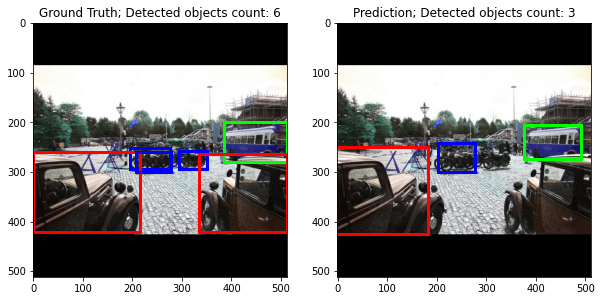

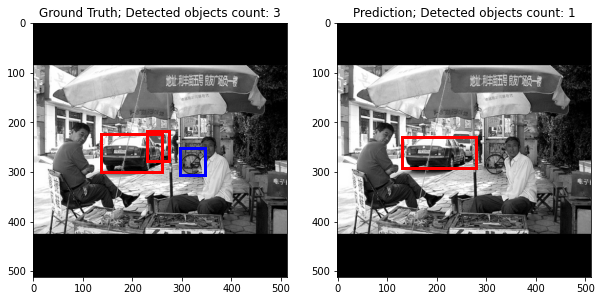

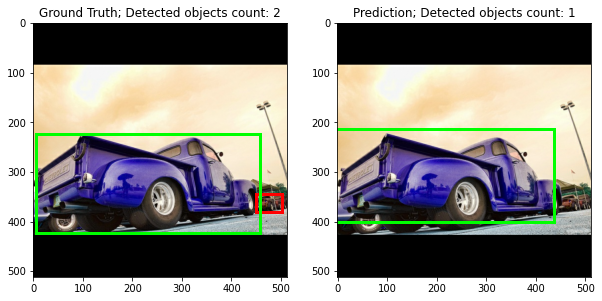

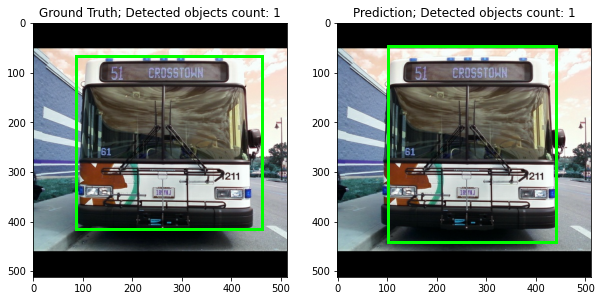

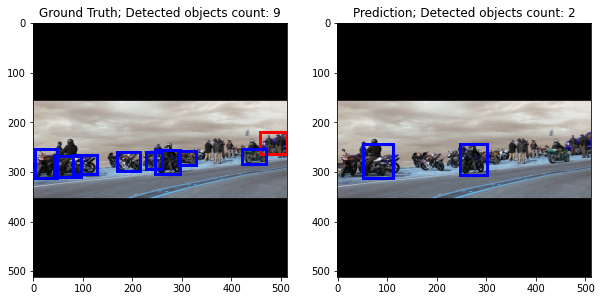

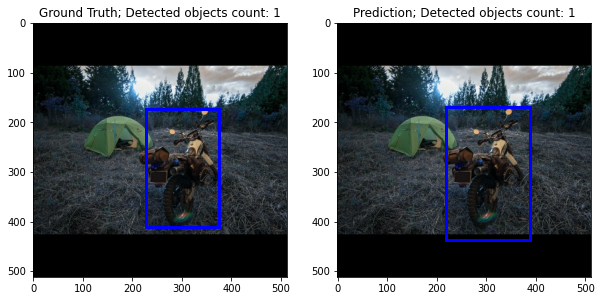

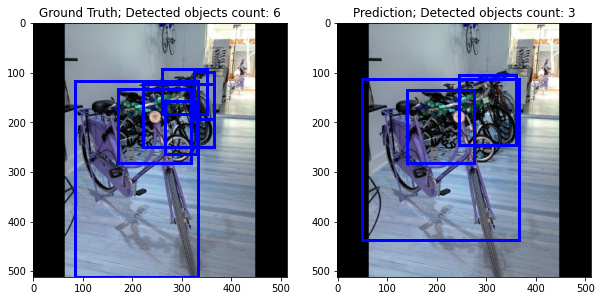

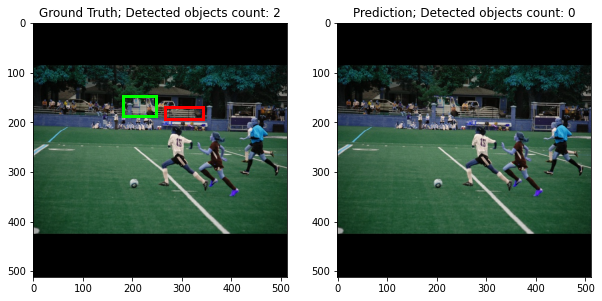

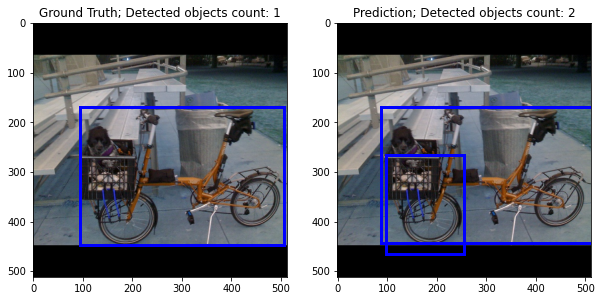

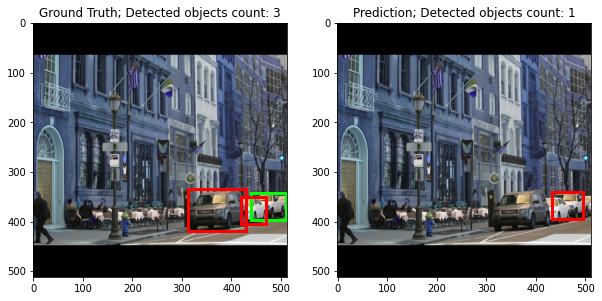

In [52]:
score = SCORE_THRESHOLD
iou_threshold = IOU_THRESHOLD

#score = 0.55
#iou_threshold = 0.35

score = 0.60
iou_threshold = 0.25

for i in range(1):
    img, detector_mask, matching_true_boxes, class_one_hot, true_boxe_grid = next(val_gen)
    display_yolo(img, true_boxe_grid, model, score, iou_threshold)

## 5.3. Display results

In [37]:
# tensorboard results from log_folder  drive/'My Drive'/'Colab Notebooks'/mqi-project/logs
#!kill 2237
#%tensorboard --logdir drive/'My Drive'/'Colab Notebooks'/mqi-project/logs

In [38]:
def compute_mAP(model, val_gen, n_val_batches, score, iou_threshold, iou_threshold_ap):
  '''
  computes mAP and precision recall curve for given thresholds
  '''
  mAP = 0
  APl = []
  PRl = []
  PrecisionSmoothl = []
  confidencesl = []
  for i in range(CLASS):  #i=0 -> car, i=1 -> truck, i=2 -> bicycle
    AP, PR, PrecisionSmooth, confidences = average_precision(model, val_gen, n_val_batches, i, totClass[i], score, iou_threshold, iou_threshold_ap)
    APl.append(AP)
    PRl.append(PR)
    PrecisionSmoothl.append(PrecisionSmooth)
    confidencesl.append(confidences)
    # mean average precision
    mAP += AP / CLASS
  return APl, PRl, PrecisionSmoothl, confidencesl, mAP

def display_mAP(APltot, PRltot, PrecisionSmoothltot, confidencesltot, mAPtot, thresholds, colors):
  '''
  displays various PR curves given in function parameters
  '''
  fig, axs = plt.subplots(3, CLASS, figsize=(20,18))

  # legend
  handles = []  
  for k in range(len(thresholds)):
    handles.append(patches.Patch(color=colors.get(k, (1,1,1)), label=f"score threshold:{thresholds[k][0]:.2f};  iou threshold:{thresholds[k][1]:.2f}"))

  for j in range(len(APltot)):
    print(f"===============\nValues for score threshold at {thresholds[j][0]}; iou threshold for nonmax suppression at {thresholds[j][1]}:")
    APl = APltot[j]
    PRl = PRltot[j]
    PrecisionSmoothl = PrecisionSmoothltot[j]
    confidencesl = confidencesltot[j]
    mAP = mAPtot[j]
    color = colors.get(j, (1,1,1))
    for i in range(CLASS):
      AP = APl[i]
      print(f"average precision for {LABELS[i]}: AP@{IOU_THRESHOLD_AP} = {AP:.3f}")  
      PR = PRl[i]
      PrecisionSmooth = PrecisionSmoothl[i]
      confidences = confidencesl[i]
      precisions, recalls = map(list, zip(*PR))
      axs[0, i].plot(recalls, precisions, color = color) 
      axs[0, i].set_title(f"PR curve {LABELS[i]}")
      axs[0, i].set_xlim(0)
      axs[0, i].set_ylim(0,1)
      axs[0, i].set_xlabel("recall")
      axs[0, i].set_ylabel("precision")
      axs[1, i].plot(recalls, PrecisionSmooth, color = color) 
      axs[1, i].set_title(f"smoothed PR curve {LABELS[i]}")
      axs[1, i].set_xlim(0)
      axs[1, i].set_ylim(0,1)
      axs[1, i].set_xlabel("recall")
      axs[1, i].set_ylabel("max precision")
      axs[2, i].set_title(f"confidence (objectness) curve {LABELS[i]}")
      axs[2, i].plot(confidences, color = color)
      axs[2, i].set_ylabel("confidence (objectness)")
      axs[2, i].set_xlim(0)

      # legend
      axs[0, i].legend(handles=handles)
      axs[1, i].legend(handles=handles)
      axs[2, i].legend(handles=handles)
    print(f"mean average precision: mAP@{IOU_THRESHOLD_AP} = {mAP:.3f}\n===============\n\n")

In [ ]:
# compute average precision and mAP@IOU_THRESHOLD_AP
iou_threshold_ap = IOU_THRESHOLD_AP

# given in format [(score_threshold1, iou_threshold1), (score_threshold2, iou_threshold2), ...]
thresholds = [(0.5, 0.45), (0.55, 0.35), (0.6, 0.25)]
# thresholds = [(0.5, 0.45)]

colors = {0:(0,0,1),1:(0,1,0),2:(1,0,0)}

APltot = []
PRltot = []
PrecisionSmoothltot = []
confidencesltot = []
mAPtot = []

for i in range(len(thresholds)):
  score = thresholds[i][0]
  iou_threshold = thresholds[i][1]
  APl, PRl, PrecisionSmoothl, confidencesl, mAP = compute_mAP(model, val_gen, n_val_batches, score, iou_threshold, iou_threshold_ap)
  APltot.append(APl)
  PRltot.append(PRl)
  PrecisionSmoothltot.append(PrecisionSmoothl)
  confidencesltot.append(confidencesl)
  mAPtot.append(mAP)

Values for score threshold at 0.5; iou threshold for nonmax suppression at 0.45:
average precision for car: AP@0.5 = 0.472
average precision for truck: AP@0.5 = 0.669
average precision for bicycle: AP@0.5 = 0.584
mean average precision: mAP@0.5 = 0.575


Values for score threshold at 0.55; iou threshold for nonmax suppression at 0.35:
average precision for car: AP@0.5 = 0.434
average precision for truck: AP@0.5 = 0.629
average precision for bicycle: AP@0.5 = 0.553
mean average precision: mAP@0.5 = 0.539


Values for score threshold at 0.6; iou threshold for nonmax suppression at 0.25:
average precision for car: AP@0.5 = 0.340
average precision for truck: AP@0.5 = 0.580
average precision for bicycle: AP@0.5 = 0.499
mean average precision: mAP@0.5 = 0.473




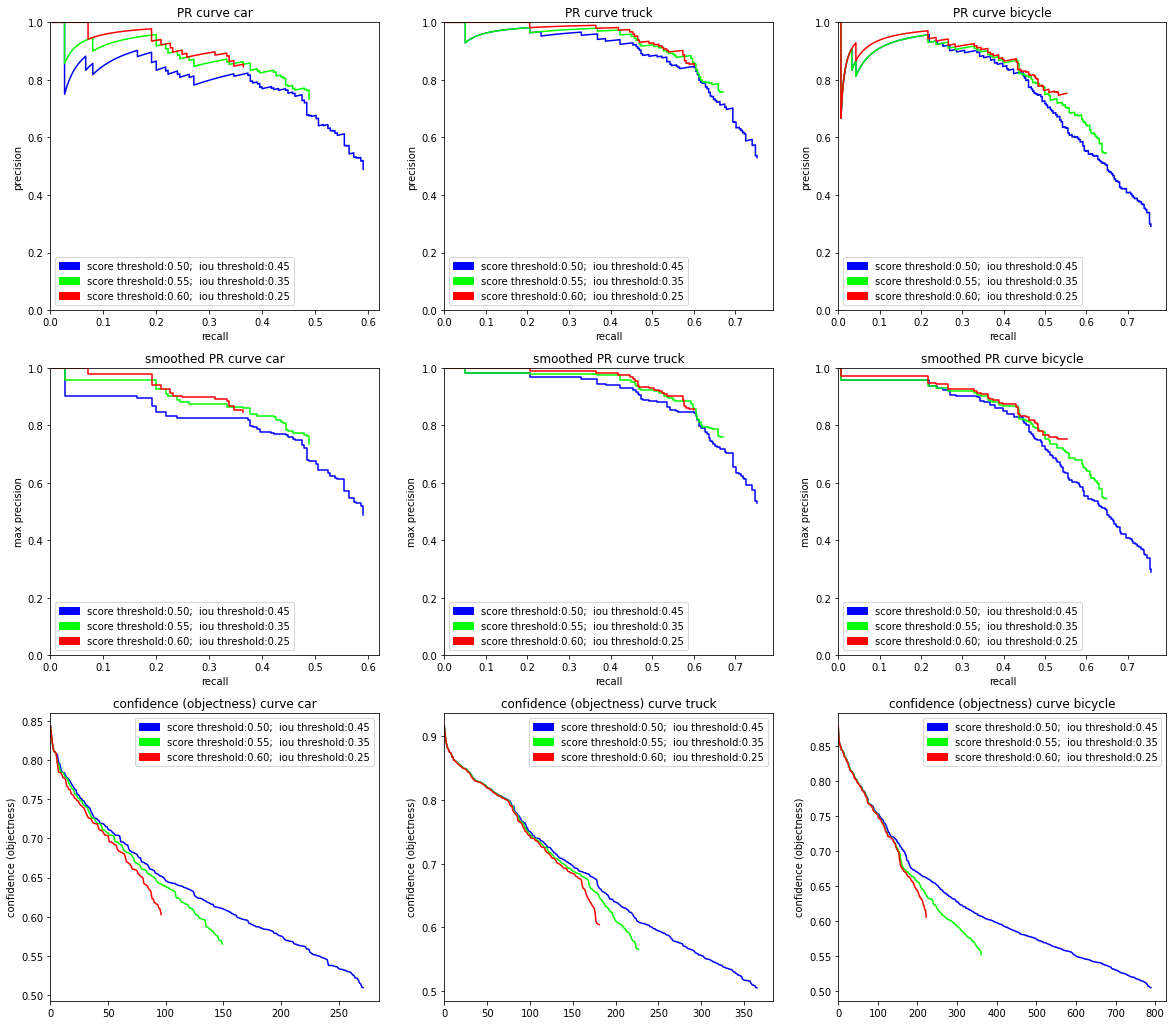

In [ ]:
# display average precision
display_mAP(APltot, PRltot, PrecisionSmoothltot, confidencesltot, mAPtot, thresholds, colors)

In [60]:
def display_mAP_coco(APltot, PRltot, PrecisionSmoothltot, confidencesltot, mAPtot, thresholds, colors):
  '''
  displays various PR curves given in function parameters
  '''
  fig, axs = plt.subplots(3, CLASS, figsize=(20,18))

  # legend
  handles = []  
  for k in range(len(thresholds)):
    handles.append(patches.Patch(color=colors.get(k, (1,1,1)), label=f"{thresholds[k]:.2f}"))

  for j in range(len(APltot)):
    APl = APltot[j]
    PRl = PRltot[j]
    PrecisionSmoothl = PrecisionSmoothltot[j]
    confidencesl = confidencesltot[j]
    mAP = mAPtot[j]
    color = colors.get(j, (1,1,1))
    for i in range(CLASS):
      AP = APl[i]
      PR = PRl[i]
      PrecisionSmooth = PrecisionSmoothl[i]
      confidences = confidencesl[i]
      precisions, recalls = map(list, zip(*PR))
      axs[0, i].plot(recalls, precisions, color = color) 
      axs[0, i].set_title(f"PR curve {LABELS[i]}")
      axs[0, i].set_xlim(0)
      axs[0, i].set_ylim(0,1)
      axs[0, i].set_xlabel("recall")
      axs[0, i].set_ylabel("precision")
      axs[1, i].plot(recalls, PrecisionSmooth, color = color) 
      axs[1, i].set_title(f"smoothed PR curve {LABELS[i]}")
      axs[1, i].set_xlim(0)
      axs[1, i].set_ylim(0,1)
      axs[1, i].set_xlabel("recall")
      axs[1, i].set_ylabel("max precision")
      axs[2, i].set_title(f"confidence (objectness) curve {LABELS[i]}")
      axs[2, i].plot(confidences, color = color)
      axs[2, i].set_ylabel("confidence (objectness)")
      axs[2, i].set_xlim(0)

      # legend
      axs[0, i].legend(handles=handles)
      axs[1, i].legend(handles=handles)
      axs[2, i].legend(handles=handles)

In [53]:
# COCO challenge

#SCORE_THRESHOLD  = 0.50
#IOU_THRESHOLD    = 0.45

# COCO mAP (iou_threshold from 0.5 to 0.95 with 0.05 steps)
coco_iou_thresholds = [0.5 + 0.05*i for i in range(10)]
# compute mAPs
mAPs = []
# arrays
APt, PRt, PrecisionSmootht, confidencest = [], [], [], []
for j in range(len(coco_iou_thresholds)):
  mAP = 0
  APc, PRc, PrecisionSmoothc, confidencesc = [], [], [], []
  for i in range(CLASS):  #i=0 -> car, i=1 -> truck, i=2 -> bicycle
    AP, PR, PrecisionSmooth, confidences = average_precision(model, val_gen, n_val_batches, i, totClass[i], SCORE_THRESHOLD, IOU_THRESHOLD, coco_iou_thresholds[j])
    APc.append(AP)
    PRc.append(PR)
    PrecisionSmoothc.append(PrecisionSmooth)
    confidencesc.append(confidences) 
    # mean average precision
    mAP += AP / CLASS
  APt.append(APc)
  PRt.append(PRc)
  PrecisionSmootht.append(PrecisionSmoothc)
  confidencest.append(confidencesc)
  mAPs.append(mAP)


coco challenge mAP@0.50 = 0.575
car AP@0.50 = 0.472 truck AP@0.50 = 0.669 bicycle AP@0.50 = 0.584 
coco challenge mAP@0.55 = 0.537
car AP@0.55 = 0.440 truck AP@0.55 = 0.636 bicycle AP@0.55 = 0.535 
coco challenge mAP@0.60 = 0.482
car AP@0.60 = 0.398 truck AP@0.60 = 0.613 bicycle AP@0.60 = 0.437 
coco challenge mAP@0.65 = 0.394
car AP@0.65 = 0.295 truck AP@0.65 = 0.534 bicycle AP@0.65 = 0.354 
coco challenge mAP@0.70 = 0.260
car AP@0.70 = 0.149 truck AP@0.70 = 0.409 bicycle AP@0.70 = 0.223 
coco challenge mAP@0.75 = 0.174
car AP@0.75 = 0.078 truck AP@0.75 = 0.307 bicycle AP@0.75 = 0.135 
coco challenge mAP@0.80 = 0.096
car AP@0.80 = 0.029 truck AP@0.80 = 0.184 bicycle AP@0.80 = 0.075 
coco challenge mAP@0.85 = 0.027
car AP@0.85 = 0.008 truck AP@0.85 = 0.063 bicycle AP@0.85 = 0.011 
coco challenge mAP@0.90 = 0.005
car AP@0.90 = 0.003 truck AP@0.90 = 0.006 bicycle AP@0.90 = 0.004 
coco challenge mAP@0.95 = 0.000
car AP@0.95 = 0.000 truck AP@0.95 = 0.000 bicycle AP@0.95 = 0.000 =====
coco

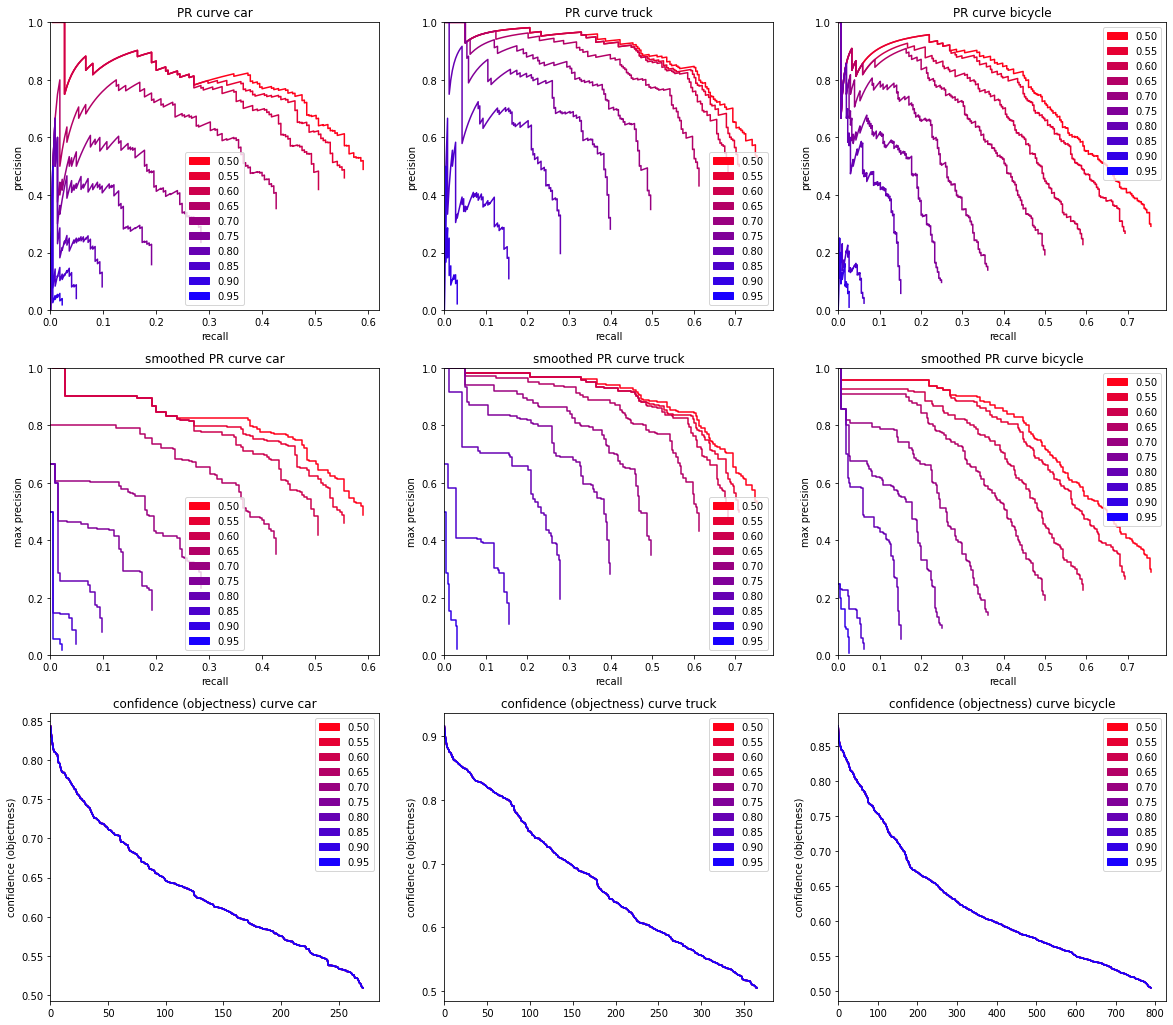

In [63]:
# print results
for i in range(len(coco_iou_thresholds)):
  print(f"\ncoco challenge mAP@{coco_iou_thresholds[i]:.2f} = {mAPs[i]:.3f}")
  for j in range(CLASS):
    print(f"{LABELS[j]} AP@{coco_iou_thresholds[i]:.2f} = {APt[i][j]:.3f} ", end='')
print(f"=====\ncoco challenge final mAP = {np.mean(np.array(mAPs)):.3f}")

colors = dict()
for i in range(10):
  colors[i] = (1 - 0.1*i,0,0.1 + 0.1*i)

# display results
display_mAP_coco(APt, PRt, PrecisionSmootht, confidencest, mAPs, coco_iou_thresholds, colors)